In [1]:
!pip install -U pygame

In [2]:
import numpy as np
import gym
from gym import spaces
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
from networkx.drawing.nx_pydot import write_dot

import pygame
from sklearn.preprocessing import normalize
import graphviz
from graphviz import Source
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))


pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
#model
MAX_SILENT_TIME = 6
SILENT_THRESHOLD = 3
BATTERY_SIZE = 6
DISCHARGE = 2
MINIMAL_CHARGE = 2
CHARGE = 1

#learning params
GAMMA = 0.99
P_LOSS = 0.1

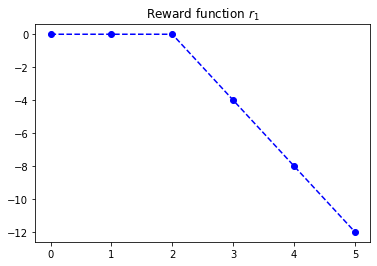

r_1 array:  [0 0 -0 -4 -8 -12]
[[-81.5 -89.7 -97.6 -106 -113 -117]
 [-74 -82.3 -90.6 -98.5 -103 -107]
 [-70.1 -74.8 -83.1 -91.5 -95.5 -95.5]
 [-70.1 -70.8 -75.5 -79.9 -84.3 -84.3]
 [-70.1 -70.8 -71.5 -72.3 -72.7 -73.1]
 [-68.9 -69.6 -70.3 -71.2 -71.6 -72]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]]


In [9]:
state_time = range(MAX_SILENT_TIME)
reward_1 = np.append(np.zeros(SILENT_THRESHOLD-1),-1*np.linspace(0, 4*(MAX_SILENT_TIME  - SILENT_THRESHOLD), MAX_SILENT_TIME  - SILENT_THRESHOLD+1))

#plot reward function in use
plt.plot(range(len(reward_1)),reward_1 , 'o--' , color = 'blue')
plt.xticks(range(MAX_SILENT_TIME))
plt.title('Reward function $r_1$')
plt.show()
print('r_1 array: ' , reward_1)

state_energy = range(BATTERY_SIZE)
state_space_size = [len(state_energy),len(state_time)]

#Screen size of state space value/policy image
screen = pygame.display.set_mode((MAX_SILENT_TIME*100, BATTERY_SIZE*100))

#init random policy
policy = np.random.randint(2, size = (len(state_energy),len(state_time)))
state_value = np.zeros(shape = (len(state_energy),len(state_time)))

def policy_evaluation():
  theta = 0.0001
  delta = 0.0
  value_change = True
  iterations = 0
  converged = False
  while not converged:
    #run value iteration
    delta = 0.0
    for energy in range(state_value.shape[0]):
      for time in range(state_value.shape[1]): 
        iterations +=1
        v = state_value[energy,time]
        if energy < MINIMAL_CHARGE: #Not enough charge, can't transmit (charge, increase time)
          state_value[energy,time] = reward_1[min(time, MAX_SILENT_TIME-1)] + GAMMA*state_value[energy+CHARGE, min(time+1, MAX_SILENT_TIME-1)] 
        elif energy> BATTERY_SIZE-DISCHARGE-1: #Transmit and discharge for collision or sucsess, or don't transmit while battery full
          if int(policy[energy,time]) == 1:
            state_value[energy,time] = ((1-P_LOSS)*(reward_1[0] + GAMMA*state_value[energy-DISCHARGE,0]))+(P_LOSS*(reward_1[time] + GAMMA*state_value[energy-DISCHARGE,min(time+1, MAX_SILENT_TIME-1)]))
          else:
            state_value[energy,time] = reward_1[min(time+1, MAX_SILENT_TIME-1)] + GAMMA*state_value[energy, min(time+1, MAX_SILENT_TIME-1)]
        else: #Transmit and discharge for collision or sucsess, or don't transmit and charge
          if int(policy[energy,time]) == 1:
            state_value[energy,time] = ((1-P_LOSS)*(reward_1[0] + GAMMA*state_value[energy-DISCHARGE,0]))+(P_LOSS*(reward_1[time] + GAMMA*state_value[energy-DISCHARGE,min(time+1, MAX_SILENT_TIME-1)]))
          else:
            state_value[energy,time] = reward_1[min(time+1, MAX_SILENT_TIME-1)] + GAMMA*state_value[energy+CHARGE,min(time+1, MAX_SILENT_TIME-1)]
        delta = np.max([delta,np.abs(v-state_value[energy,time])])
        #print(delta,np.abs(v-state_value[energy,time]),v, state_value[energy,time])
        converged = True if delta < theta else False
  

def policy_improvment():
  for energy in range(state_value.shape[0]):
    for time in range(state_value.shape[1]):
      a = policy[energy,time]
      if energy < MINIMAL_CHARGE:
        policy[energy,time] = 0
      elif energy> BATTERY_SIZE-DISCHARGE-1:
        policy[energy,time] = np.argmax([(reward_1[min(time+1, MAX_SILENT_TIME-1)] + GAMMA * state_value[energy,min(time+1, MAX_SILENT_TIME-1)]),((1-P_LOSS)*(reward_1[0] + GAMMA*state_value[energy-DISCHARGE,0])+P_LOSS*(reward_1[time] + GAMMA*state_value[energy-DISCHARGE,min(time+1, MAX_SILENT_TIME-1)]))]) #max(transmit good + transmit bad, wait)
      else:
        policy[energy,time] = np.argmax([(reward_1[min(time+1, MAX_SILENT_TIME-1)]* + GAMMA * state_value[energy+CHARGE,min(time+1, MAX_SILENT_TIME-1)]),((1-P_LOSS)*(reward_1[0] + GAMMA*state_value[energy-DISCHARGE,0])+P_LOSS*(reward_1[time] + GAMMA*state_value[energy-DISCHARGE,min(time+1, MAX_SILENT_TIME-1)]))]) #max(transmit good + transmit bad, wait)
      if a != policy[energy,time]:
        policy_stable = False     
  if policy_stable:
    return policy_stable
  else:
    policy_evaluation()

#evaluate initial policy
policy_improvment()

print(state_value) 
print(policy)